## Import

In [6]:
import math
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Hyperparameter Setting

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(2023) # Seed 고정

### 데이터 불러오기

In [9]:
train_info = pd.read_csv('./train.csv').drop(columns=['제품'])
# brand_keyword_cnt = pd.read_csv('./data/brand_keyword_cnt.csv')
# product_info = pd.read_csv('./data/product_info.csv')
# sales = pd.read_csv('./data/sales.csv')

### 데이터 전처리

In [10]:
train_info['ID'] = train_info['ID'].astype(int)
train_info['대분류'] = train_info['대분류'].str.split('-').str.get(2)
train_info['중분류'] = train_info['대분류']+'-'+train_info['중분류'].str.split('-').str.get(2)
train_info['소분류'] = train_info['중분류']+'-'+train_info['소분류'].str.split('-').str.get(2)
train_info['브랜드'] = train_info['소분류']+'-'+train_info['브랜드'].str.split('-').str.get(1)
train_info.head(2)

,ID,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,0002,0002-0007,0002-0007-0038,0002-0007-0038-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0003,0003-0008,0003-0008-0044,0003-0008-0044-00002,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0


In [11]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_info[col])
    train_info[col] = label_encoder.transform(train_info[col])

In [12]:
# info Scaling
scale_max_dict = {}
scale_min_dict = {}
all_same_value_dict = {}

for idx in tqdm(range(len(train_info))):
    maxi = np.max(train_info.iloc[idx,5:])
    mini = np.min(train_info.iloc[idx,5:])
    
    if maxi == mini :
        # train_info.iloc[idx,5:] = 0
        all_same_value_dict[idx]=maxi
    else:
        train_info.iloc[idx,5:] = (train_info.iloc[idx,5:] - mini) / (maxi - mini)
    
        scale_max_dict[idx] = maxi
        scale_min_dict[idx] = mini

  0%|          | 0/15890 [00:00<?, ?it/s]

In [13]:
data = train_info.copy(deep=True).drop(all_same_value_dict.keys(),axis=0)

In [14]:
iw=68
ow=34
batch_size = 64*2

In [16]:
def make_datetime_info(datetime:pd.DataFrame):
    datetime['day'] = datetime['datetime'].dt.day
    datetime['month'] = datetime['datetime'].dt.month
    datetime['day_of_week'] = datetime['datetime'].dt.day_of_week
    # datetime['day_of_year'] = datetime['datetime'].dt.day_of_year
    datetime['quarter'] = datetime['datetime'].dt.quarter
    datetime.drop(labels='datetime',axis=1,inplace=True)
    return datetime

def make_train_data(data:pd.DataFrame, train_size=iw, predict_size=ow):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
    ID = data['ID']
    window_size = train_size + predict_size
    
    sales_data = data.iloc[:,5:].T.to_numpy()
    
    total_sum_data = data.iloc[:,5:].sum().to_numpy()
    product_id_cnt = len(data)
    
    datetime = pd.DataFrame(pd.to_datetime(data.iloc[:1,5:].columns), columns=['datetime'])
    # print(datetime)
    datetime_info = make_datetime_info(datetime)
    datetime_info_col_cnt = len(datetime_info.columns)
    datetime_info = np.array(datetime_info)
    
    input_data  = np.empty(((len(datetime_info) - window_size + 1), train_size,   datetime_info_col_cnt + 1 + product_id_cnt))
    target_data = np.empty(((len(datetime_info) - window_size + 1), predict_size,1+ product_id_cnt))
    
    
    for window_index in range(len(datetime_info) - window_size + 1):
        window           =     sales_data[window_index:window_index+window_size]
        datetime_window  =  datetime_info[window_index:window_index+train_size]
        partial_sum_data = total_sum_data[window_index:window_index+window_size]
            
        temp_data = np.column_stack((datetime_window, window[:train_size], partial_sum_data[:train_size]))
        input_data[window_index] = temp_data
        target_data[window_index] = np.column_stack((window[train_size:],partial_sum_data[train_size:]))
    
    return input_data, target_data, ID

In [17]:
def make_predict_data(data, train_size=iw):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    sales_data = data.iloc[:,5:].T.to_numpy()
    
    total_sum_data = data.iloc[:,5:].sum().to_numpy()
    product_id_cnt = len(data)
    
    datetime = pd.DataFrame(pd.to_datetime(data.iloc[:1,5:].columns), columns=['datetime'])
    datetime_info = make_datetime_info(datetime)
    datetime_info_col_cnt = len(datetime_info.columns)
    datetime_info = np.array(datetime_info)
    
    window           = sales_data[-train_size:]
    datetime_window  = datetime_info[-train_size:]
    partial_sum_data = total_sum_data[-train_size:]
    
    input_data = np.empty((1, train_size, datetime_info_col_cnt + 1 + product_id_cnt))
    
    
    # window = sales_data[-train_size : ] # sales_data크기가 train_size인데 이 코드는 대체 왜 존재하는것?
    temp_data = np.column_stack((datetime_window ,window, partial_sum_data))
    input_data[0] = temp_data
    
    return input_data

In [18]:
data['소분류'].nunique()

53

In [19]:
all_samll_category_data = []
for i in range(data['소분류'].nunique()): # 53
    partial_data = data[data['소분류']==i]
    train_data, label_data, ID = make_train_data(partial_data.iloc[:,:-(34+7)], train_size=iw, predict_size=ow)
    predict_data = make_predict_data(partial_data.iloc[:,:-(34+7)], train_size=iw)
    all_samll_category_data.append([train_data, label_data, ID, predict_data])

### Custom Dataset

In [20]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

### 모델 선언

In [21]:
"""
iw: input window
ow: output window

"""
class TFModel(nn.Module):
    def __init__(self,iw=68, ow=34, d_model=512*2, nhead=8, nlayers=4,encode_info_size=756, dropout=0.1):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.encode_info_size = encode_info_size
        
        self.encoder = nn.Sequential(
            nn.Linear(encode_info_size, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, encode_info_size)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, iw),
            nn.ReLU(),
            nn.Linear(iw, ow)
        ) 

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)     #=> [batch, input_window, d_model]
        src = self.pos_encoder(src) #=> [batch, input_window, d_model]
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1) #=> [batch, input_window, d_model]
        output = self.linear(output)    #=> [batch, input_window, encode_info_size]
        output = output.permute(0,2,1)  #=> [batch, encode_info_size, input_window] 
        # print(output.shape)             #   torch.Size([68, 756, 180])                .
        output = self.linear2(output)   # [batch, encode_info_size, output_window] tensor to be: [68, 180] but got: [68, 68]
        output = output.permute(0,2,1)  # [batch, output_window, encode_info_size]
        return output[:,:,-self.encode_info_size+4:]          

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

### 모델 학습

In [22]:
def train(model, optimizer, train_loader, epoch, loss_limit, device):
    model.to(device)
    # criterion = nn.MSELoss().to(device)
    criterion = nn.MSELoss().to(device)    
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000,2000,3000,4000,5000,6000,7000,8000,9000,10000], gamma=0.5)
    min_loss = 1e100
    mean_loss = None
    cnt = 0
    best_model = None
    for epoch in range(1, epoch+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in train_loader:
            
            optimizer.zero_grad()
            src_mask = model.generate_square_subsequent_mask(X.shape[1]).to(device)
            output = model(X.to(device),src_mask)
            loss = criterion(output, Y.to(device))
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        
        mean_loss = np.mean(train_loss)
        if min_loss>mean_loss:
            min_loss=mean_loss
            best_model = model
            cnt = 0
        else:
            cnt +=1
        
        scheduler.step()
        if epoch%200==0:
            print(f'Epoch : [{epoch}] Train Loss : [{mean_loss:.5f}]')
        
        if mean_loss<loss_limit and cnt>100:
            print(f'Train Loss : [{mean_loss:.5f}]')
            return model,best_model
    print(f'Train Loss : [{mean_loss:.5f}]')
    return model,best_model

In [23]:
def inference(model, test_loader, device):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X in test_loader:
            X = X.to(device)
            src_mask = model.generate_square_subsequent_mask(X.shape[1]).to(device)
            output = model(X,src_mask)
            
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            
            predictions.extend(output)
    model.to(torch.device("cpu"))
    torch.cuda.empty_cache()
    return np.array(predictions)

## Run !!

In [24]:
all_loaders = []
for [train_data, label_data, ID, predict_data] in all_samll_category_data:
    train_dataset = CustomDataset(train_data, label_data)
    train_loader = DataLoader(train_dataset, 
                              batch_size =batch_size, 
                              shuffle = True, 
                              num_workers = 6)
    test_dataset = CustomDataset(predict_data, None)
    test_loader = DataLoader(test_dataset, 
                             batch_size = batch_size, 
                             shuffle = False, 
                             num_workers = 6)
    all_loaders.append([train_loader,test_loader,ID])

각 소분류 개수
[ 751,  663, 1426,  426,  342,  160,  175,  262,  112,  183,  113, 
  101,   75,  104,  236,  466,  342,  222,   71,  140,  112,  195,
  356,  365,  289,  690,  150,  408,  174,  198,  366,  153,   57,
  265,  180, 1020,  641,  362,  184,  431,  432,  451,  294,  223,
  162,  194,   59,  117,  234,   34,  111,  392,  221]

In [25]:
all_models = []
for i,[train_loader,test_loader,ID] in enumerate(all_loaders):
    print(f'*********************소분류{i} 훈련시작!************************')
    model = TFModel(encode_info_size=1+4+len(ID))
    set_loss_limit = 0.006*(len(ID)+1)/752
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4,weight_decay=0)
    model,best_model = train(model, optimizer, train_loader,epoch=2000, loss_limit=set_loss_limit,device=device)
    all_models.append([model.to(torch.device("cpu")).eval(),best_model.to(torch.device("cpu")).eval()])
    torch.cuda.empty_cache()

*********************소분류0 훈련시작!************************
Epoch : [200] Train Loss : [0.21882]
Epoch : [400] Train Loss : [0.06398]
Epoch : [600] Train Loss : [0.02994]
Epoch : [800] Train Loss : [0.01991]
Epoch : [1000] Train Loss : [0.01519]
Epoch : [1200] Train Loss : [0.01252]
Epoch : [1400] Train Loss : [0.01142]
Epoch : [1600] Train Loss : [0.01017]
Epoch : [1800] Train Loss : [0.00892]
Epoch : [2000] Train Loss : [0.00834]
Train Loss : [0.00834]
*********************소분류1 훈련시작!************************


KeyboardInterrupt: 

## 모델 추론

In [ ]:
#take best model
results = []
for i,[last_model,best_model,ID] in enumerate(all_models):
    test_loader = all_loaders[i][1]
    ID = all_samll_category_data[i][2]
    pred = inference(best_model, test_loader, device)
    results.append([pred,ID])

In [ ]:
data = train_info.copy(deep=True).drop(all_same_value_dict.keys(),axis=0)

In [ ]:
columns = data.iloc[:,-34-7:-7].columns
for pred,ID in results:
    pred,total = pred[0][:,:-1],pred[0][:,-1]
    pred,total = np.where(pred<0,0,pred), np.where(total<0,0,total)
    # print(pd.DataFrame(pred.T).isna().sum().sum())
    data.loc[ID,"2023-02-23":"2023-03-28"] = pd.DataFrame(pred.T,index=ID,columns=columns)

<Axes: >

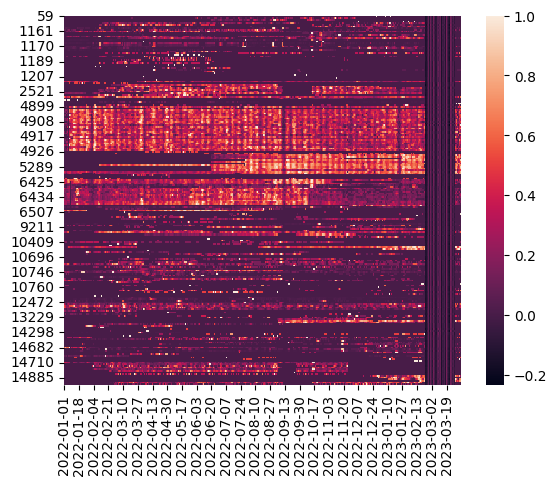

In [ ]:
sns.heatmap(data.loc[ID,"2022-01-01":])

In [ ]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
    
# 결과 후처리
pred = np.round(pred, 0).astype(int)

## Submission

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
submit.iloc[:,1:] = pred
submit.head()

ValueError: could not broadcast input array from shape (34,751) into shape (15890,21)

In [ ]:
epoch = CFG['EPOCHS']
submit.to_csv(f'./results/baseline_epoch{epoch}_labelencoding개선.csv', index=False)